# Итоговый проект по курсу "Введение в сетевой анализ"

Выполнили студенты:

* Дасаев Гарри

* Птичкина Анастасия

* Файн Егор

* Филатов Михаил



-----------------------------------------
## Парсинг сайта и подготовка текста

In [17]:
# инструменты для парсинга
import requests
from bs4 import BeautifulSoup

# работа с данными
import pandas as pd
import numpy as np

# обработка текста
import re
import nltk
from nltk.corpus import stopwords
import pymorphy2

# визуализация и работа с сетями
import networkx as nx
from networkx.algorithms import community # поиск сообществ
import matplotlib.pyplot as plt
% matplotlib inline

# стоп-слова и лемматизатор
nltk.download("stopwords") 
stops = set(stopwords.words("russian"))  
morph = pymorphy2.MorphAnalyzer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Misha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# выгрузка данных с сайта и подготовка к работе с HTML
url = 'http://kremlin.ru/events/president/news/59863'
html = requests.get(url, 'xlml')
soup = BeautifulSoup(html.text, 'lxml')

In [16]:
putin_text = ''.join([i.text for i in soup.find_all('p')][5:135]) # текст послания
putin_text = putin_text.replace('\xa0', ' ').replace('\n', ' ').lower() # удаление ненужных пробелов

In [11]:
# Создание словаря для дальнейшей работы
norm_putin_text = [morph.parse(i)[0].normal_form for i in  re.findall('\w+', putin_text) if i not in stops]

In [12]:
# Выделение биграмм из текста
bigr = [i for i in nltk.bigrams(norm_putin_text)]

Создаем граф.

In [18]:
G = nx.Graph()

In [19]:
G.add_edges_from(bigr)

## Центральности и распределение вершин

Сначала визуализируем граф.

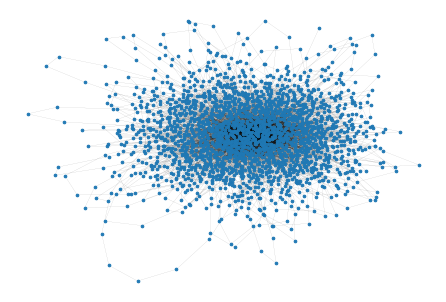

In [0]:
nx.draw(G,
        layout=nx.spring_layout(G,k=0.075,iterations=20, scale=3),
        with_labels=False,
        node_size=7, width=0.05,
        seed=228)

plt.show()

Тперь посмотрим на его диаметр радиус и плотность, а также количество вершин и ребер.

In [20]:
print('Количество вершин в графе:', G.number_of_nodes())
print('Количество ребер в графе:', G.number_of_edges())
print('Диаметр графа:', nx.diameter(G))
print('Радиус графа:', nx.radius(G))
print('Плотность графа:', G.number_of_edges()/((G.number_of_nodes())*((G.number_of_nodes())-1)))
print('Транзитивность:', nx.transitivity(G))

Количество вершин в графе: 2306
Количество ребер в графе: 6173
Диаметр графа: 10
Радиус графа: 6
Плотность графа: 0.0011613578084521564
Транзитивность: 0.029316854904439527


Можно заметить, что плотность графа очень мала ввиду специфичности данных. Посмотрим, подчиняется ли сеть степенному закону.

In [23]:
to_hist = list(dict(G.degree()).values())

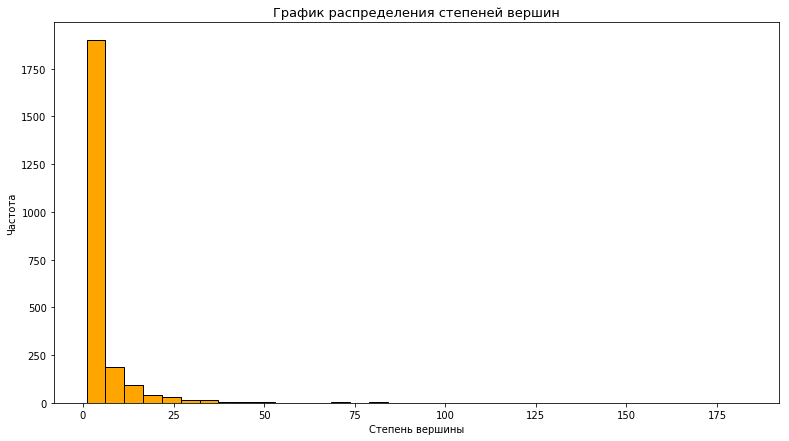

In [25]:
fig = plt.figure(figsize=(13, 7))

plt.hist(to_hist, bins=35, color='orange', edgecolor='black')
plt.title('График распределения степеней вершин', size=13)
plt.ylabel('Частота')
plt.xlabel('Степень вершины')

plt.show()

Да, как мы видим, сеть подчиняется степенному закону. Тперь посчитаем основные центральности для вершин графа и сохраним их в датафрейм. 

In [0]:
degree_c = list(nx.degree_centrality(G).values())
closeness_c = list(nx.closeness_centrality(G).values())
betweenness_c = list(nx.betweenness_centrality(G).values())
eigen_c = list(nx.eigenvector_centrality(G).values())
words = list(nx.eigenvector_centrality(G).keys())

centrality_data = pd.DataFrame(np.array([words, degree_c, closeness_c, betweenness_c, eigen_c]).T,
                               columns=['words', 'degree_c', 'closeness_c', 'betweenness_c', 'eigen_c'])

Отсортируем вршины графа по всем центральностям

In [0]:
centrality_data.sort_values(by='degree_c', ascending=False)[['words', 'degree_c']].head(10)

,words,degree_c
61,это,0.07939262472885032
204,год,0.055097613882863335
140,должный,0.04598698481561822
25,который,0.04338394793926247
40,человек,0.040347071583514096
15,наш,0.03774403470715835
148,нужно,0.03600867678958785
9,россия,0.0351409978308026
152,работа,0.029934924078091105
62,весь,0.029934924078091105


In [0]:
centrality_data.sort_values(by='closeness_c', ascending=False)[['words', 'closeness_c']].head(10)

,words,closeness_c
61,это,0.4099235283656411
204,год,0.3860971524288107
140,должный,0.3818121583567997
40,человек,0.37183416680109693
152,работа,0.3705192091303649
117,такой,0.3688
9,россия,0.3675063775510204
148,нужно,0.3659311001746309
15,наш,0.3652353034384408
62,весь,0.36488839639069176


In [0]:
centrality_data.sort_values(by='betweenness_c', ascending=False)[['words', 'betweenness_c']].head(10)

,words,betweenness_c
1486,юрисдикция,9.958809679168241e-05
1788,сахалинск,9.94435702224152e-06
495,немаленькая,9.913667421998048e-06
1437,предпринимательство,9.860469067948978e-05
1226,обозначить,9.842970978042434e-06
106,напрягаться,9.835496359747991e-06
1249,отдельный,9.834678692338243e-06
645,собрание,9.82407162770218e-06
1769,подход,9.821691768090844e-06
219,конкретно,9.81550155247664e-06


In [0]:
centrality_data.sort_values(by='eigen_c', ascending=False)[['words', 'eigen_c']].head(10)

,words,eigen_c
1263,республика,9.951569527231341e-05
2168,заступить,9.231113774271259e-05
1276,регулирование,9.120999549250065e-05
1787,южный,8.879115343338927e-05
852,допускать,8.832658683669738e-05
1779,тверская,8.715367611520427e-05
1055,сиделка,8.641175716072367e-05
2162,опытно,8.587195020481117e-05
1644,этап,8.095011587252467e-05
1056,обучить,7.591170517199623e-05


## Сруктурная эквивалентность и выделениие сообществ 

Теперь попробуем найти вершины, для которых характерна структурная эквивалентность. Сделаем это с помощью матрицы корреляции.



In [21]:
A = nx.to_numpy_matrix(G)
C = np.corrcoef(A)

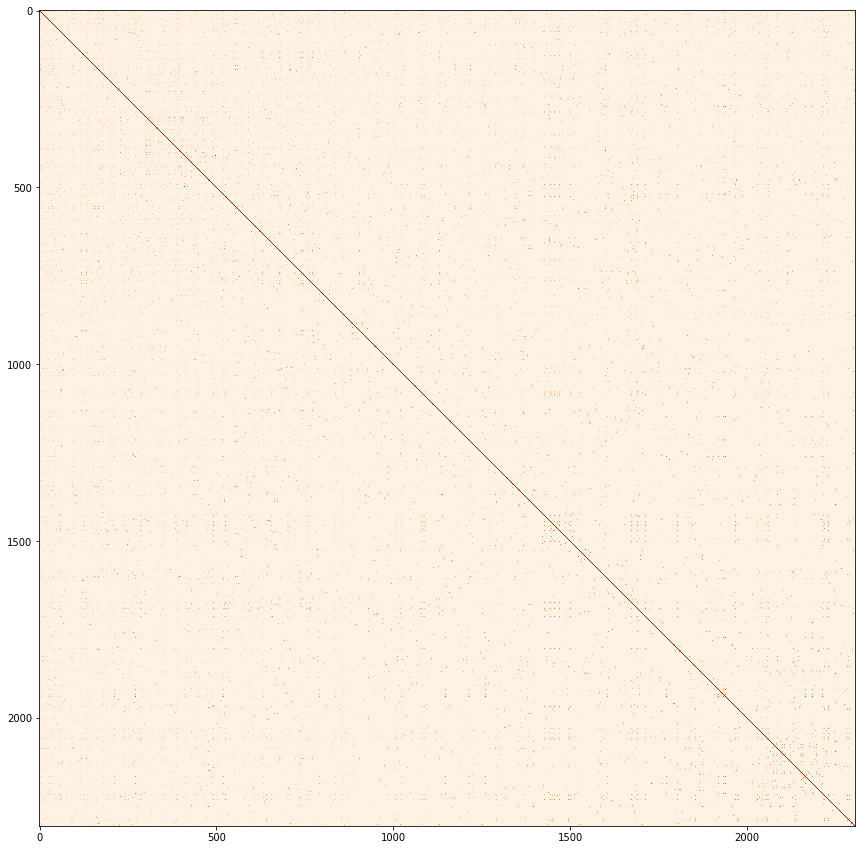

In [22]:
fig, ax = plt.subplots(figsize=(15,15))

plt.imshow(C, cmap = 'Oranges', interpolation = 'None')
plt.show()

Опять же ввиду специфичности данных, данные не сильно коррелируют между собой. Попробуем найти структурно эквивалентные вершины.

In [26]:
A = nx.to_numpy_matrix(G.to_undirected(), dtype=int)
A = pd.DataFrame(np.asarray(A), index=G.nodes, columns=G.nodes)

corr_table = A.loc[A.sum(axis=1) > 0, A.sum(axis=1) > 0].corr()  # выкидываем нулевые столбцы
corr_pairs = pd.DataFrame(corr_table.unstack().sort_values(kind="quicksort", ascending=False)).reset_index()  # находим пары корреляций
corr_pairs.columns = ['node_1', 'node_2', 'coef']
corr_pairs['flag_non_unique'] = (corr_pairs['node_1'] != corr_pairs['node_2']).astype('int')  # ищем две разные вершины в паре
nodes_str_eq = corr_pairs[(corr_pairs.flag_non_unique == 1) & (corr_pairs.coef == 1.)]

nodes_str_eq

,node_1,node_2,coef,flag_non_unique
46,помогать,точно,1.0,1
73,критически,крайне,1.0,1
148,точно,помогать,1.0,1
219,критически,чрезвычайно,1.0,1
224,избавляться,жёстко,1.0,1
262,жёстко,избавляться,1.0,1
348,заострить,обратить,1.0,1
353,челябинский,пермский,1.0,1
384,нарушение,осуществляться,1.0,1
595,специально,неправда,1.0,1


Можно заметить, что структурно эквивалентные вершины в графе являются по сути дела словами синонимами.

## Выделение сообществ и поиск клик

Теперь выделим сообщества в графе. Начнем с метода `greedy modularity communities`.

In [0]:
communities_generator = community.greedy_modularity_communities(G)

In [0]:
char_com = []
for i, j in enumerate(communities_generator):
    for k in j:
        char_com.append((k, i))

dict_com = dict(char_com)

In [0]:
nx.set_node_attributes(G, dict_com, name='greedy_mod_com')

Теперь посмотрим количество кластеров, которые получились с помощью метода `greedy modularity communities`.

In [0]:
len(set(dict_com.values()))

34

Теперь на основе алгоритма асинхронных флюидных сообществ (`asyn_fluidc`)

In [0]:
asyn_communities_generator = community.asyn_fluidc(G, k=34)

In [0]:
asyn_dict = dict(zip(list(range(0,34)), [i for i in asyn_communities_generator]))

In [0]:
char_com2 = []
for i in asyn_dict:
  for j in asyn_dict[i]:
    char_com2.append((j, i))
dict_com2 = dict(char_com2) 

nx.set_node_attributes(G, dict_com2, 'fluid_com')

Теперь посмотрим на [V-меру](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score) схожести двух типов выделения сообществ.

In [0]:
from sklearn.metrics import v_measure_score

print('Схожесть выделения сообществ --', v_measure_score(list(dict_com.values()), list(dict_com2.values())))

Схожесть выделения сообществ -- 0.7588863639535537


В целом мы можем заметить, что сообщества, которые были выделены двумя методами в целом очень похожи, но все же для анализа были выбраны кластеры, которые были получены на основе `greedy modularity communities` алгоритма (интерпретация полученных кластеров приводится в отчете по проекту). Теперь выделим самые большие клики и посмотрим из каких слов они состоят. Максимальный размер клики 5, поэтому на них мы и посмотрим.

In [36]:
[i for i in list(clique.find_cliques(G)) if len(i) == 5]

[['это', 'вообще', 'её', 'хотеть', 'сделать'],
 ['это', 'сегодня', 'прямо', 'сказать', 'хотеть'],
 ['это', 'понимать', 'человек', 'делать', 'нужно']]

По сути дела клики в таком графе являются основными связующими словами для текста. Создадим атрибут для графа, который будет отвечать за наибольшие клики. В дальнейшем мы используем это для визуализации.

In [27]:
from networkx.algorithms import clique
from itertools import chain

to_viz_attr = set(chain(*[i for i in list(clique.find_cliques(G)) if len(i) == 5]))

In [28]:
clique_list = []
for node in G.nodes():
    if node in to_viz_attr:
    clique_list.append((node, 'in_cliques'))
    else:
    clique_list.append((node, 'not_in_cliques'))
clique_dict = dict(clique_list)

In [30]:
nx.set_node_attributes(G, clique_dict, 'cliques')

Сохраним файл для работы в Gephi

In [0]:
nx.write_gexf(G, "Project_SNA.gexf")